In [ ]:
!pip install transformers==3

In [ ]:
import transformers 
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import DistilBertModel, DistilBertTokenizer, RobertaTokenizer, RobertaModel
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tqdm import tqdm
from torch import nn, optim 
from torch.utils import data
from collections import defaultdict
from textwrap import wrap
from torch.utils.data import Dataset, DataLoader
from matplotlib.ticker import MaxNLocator
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 99
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Read Data

In [ ]:
df_train = pd.read_csv("sentiment_dataset_train.csv", index_col=0)
df_dev = pd.read_csv("sentiment_dataset_dev.csv", index_col=0)
df_test = pd.read_csv("sentiment_dataset_test.csv",index_col=0)

In [ ]:
def groupRating(rating):
  grp_rating = -1
  rating = int(rating)
  if rating == 1:
    grp_rating = 0
  elif rating == 2:
    grp_rating = 1
  elif rating == 3:
    grp_rating = 2
  elif rating == 4:
    grp_rating = 3
  else:
    grp_rating = 4
  return grp_rating


df_train['rating_n'] = df_train.rating.apply(groupRating)
df_dev['rating_n'] = df_dev.rating.apply(groupRating)


# Data Processing

Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (889 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (790 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Text(0.5, 0, 'length')

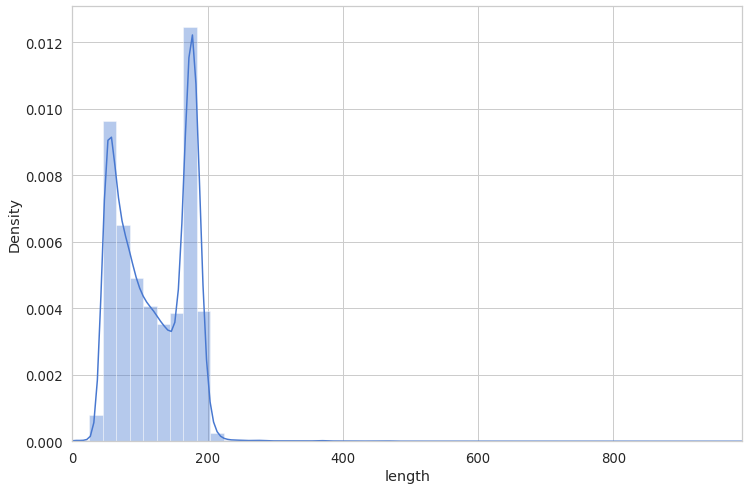

In [ ]:
#download pretrained tokenizer from bert
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

token_length=[]
for content in df_train.review:
  tokens = tokenizer.encode(content)
  token_length.append(len(tokens))

#check review's length distribution
ax = sns.distplot(token_length)
plt.xlim([0, 990]);
plt.xlabel('length')

From this distribution, the choice of max length is seemingly 220.

# Initialization

In [ ]:
# Defining some key variables
MAX_LEN = 220
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-05

# Create Dataset

In [ ]:
class Triage(data.Dataset):
  '''
  This method processes the input data (padding, truncating) and fits inside tensors
  '''
  def __init__(self, dataframe, tokenizer, max_len):
      self.len = len(dataframe)
      self.data = dataframe
      self.tokenizer = tokenizer
      self.max_len = max_len
      
  def __getitem__(self, index):
    title = str(self.data.review[index])
    title = " ".join(title.split())
    inputs = self.tokenizer.encode_plus(
      title,
      None,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True,
      return_token_type_ids=True,
      truncation=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    # This checks if the data is holdout (if yes then do not return the targets) or not
    if self.data.shape[1]<2:     
      return {
        'review_text': title,
        'ids': torch.tensor(ids, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.long),
      }  
    
    else: 
      return {
        'review_text': title,
        'ids': torch.tensor(ids, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.long),
        'targets': torch.tensor(self.data.rating_n[index], dtype=torch.long)
    } 

  def __len__(self):
    return self.len

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  '''
  this method uses the tokenizer and distributes the datasets into batches
  '''
  ds = Triage(
      dataframe = df,
      tokenizer = tokenizer,
      max_len = max_len
  )
  return data.DataLoader(
      ds,
      batch_size = BATCH_SIZE,
      num_workers = 0
  )

In [ ]:
# train-val split
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state=RANDOM_SEED)

# preprocess the data
training_loader = create_data_loader(df_train.reset_index(drop=True), tokenizer, MAX_LEN, BATCH_SIZE)
val_loader = create_data_loader(df_val.reset_index(drop=True), tokenizer, MAX_LEN, BATCH_SIZE)
test_loader = create_data_loader(df_dev.reset_index(drop=True), tokenizer, MAX_LEN, BATCH_SIZE)
holdout_loader = create_data_loader(df_test.reset_index(drop=True), tokenizer, MAX_LEN, BATCH_SIZE)

print("TRAIN Dataset: {}".format(df_train.shape))
print("VAL Dataset: {}".format(df_val.shape))
print("TEST Dataset: {}".format(df_dev.shape))
print("HOLDOUT Dataset: {}".format(df_test.shape))

TRAIN Dataset: (28003, 3)
VAL Dataset: (7001, 3)
TEST Dataset: (7499, 3)
HOLDOUT Dataset: (6500, 1)


# Define RoBERTa Model

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of Roberta to get the final output for the model. 
class ClassifierClass(torch.nn.Module):
  '''
  This method defines the customized model
  '''
  def __init__(self, n_classes):
    super(ClassifierClass, self).__init__()
    # self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
    self.l1 = RobertaModel.from_pretrained('roberta-base')
    self.pre_classifier = torch.nn.Linear(self.l1.config.hidden_size, 100)
    self.dropout = torch.nn.Dropout(0.5)
    self.classifier = torch.nn.Linear(100, n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
    hidden_state = output_1[0]
    pooler = hidden_state[:, 0]
    pooler = self.dropout(pooler)
    pooler = self.pre_classifier(pooler)
    pooler = torch.nn.ReLU()(pooler)
    pooler = self.dropout(pooler)
    output = self.classifier(pooler)
    return self.softmax(output)

In [ ]:
# set gpu
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model = ClassifierClass(len(df_train['rating'].unique()))
model.to(device)

ClassifierClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, el

# Training

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def calcuate_accu(big_idx, targets):
  n_correct = (big_idx==targets).sum().item()
  return n_correct

# Defining the training function
def train(epoch):
  '''
  This moethod runs the training epochs
  '''
  tr_loss = 0
  n_correct = 0
  nb_tr_steps = 0
  nb_tr_examples = 0
  model.train()
  for _,data in enumerate(training_loader, 0):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.long)

    outputs = model(ids, mask)
    loss = loss_function(outputs, targets)
    tr_loss += loss.item()
    big_val, big_idx = torch.max(outputs.data, dim=1)
    n_correct += calcuate_accu(big_idx, targets)

    nb_tr_steps += 1
    nb_tr_examples+=targets.size(0)
    
    # if _%5000==0:
    #     loss_step = tr_loss/nb_tr_steps
    #     accu_step = (n_correct*100)/nb_tr_examples 
    #     print(f"Training Loss per 5000 steps: {loss_step}")
    #     print(f"Training Accuracy per 5000 steps: {accu_step}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss = tr_loss/nb_tr_steps
  epoch_accu = (n_correct*100)/nb_tr_examples


  return epoch_loss , epoch_accu

In [ ]:
def val(epoch):
  '''
  This moethod runs the validation epochs
  '''
  model.eval()
  nb_tr_examples = 0
  nb_tr_steps = 0
  tr_loss = 0
  n_correct = 0
  with torch.no_grad():
    for _, data in enumerate(val_loader, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.long)

      outputs = model(ids, mask).squeeze()
      loss = loss_function(outputs, targets)
      tr_loss += loss.item()
      big_val, big_idx = torch.max(outputs.data, dim=1)
      n_correct += calcuate_accu(big_idx, targets)

      nb_tr_steps += 1
      nb_tr_examples+=targets.size(0)

      # if _%5000==0:
      #   loss_step = tr_loss/nb_tr_steps
      #   accu_step = (n_correct*100)/nb_tr_examples
      #   print(f"Validation Loss per 100 steps: {loss_step}")
      #   print(f"Validation Accuracy per 100 steps: {accu_step}")

      epoch_loss = tr_loss/nb_tr_steps
      epoch_accu = (n_correct*100)/nb_tr_examples

  return epoch_loss, epoch_accu


In [ ]:
# iterate through the epochs and save the best performing model 
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print("Epoch "+str(epoch+1)+"/"+str(EPOCHS))
  print("-"*10)
  train_loss, train_acc = train(epoch)
  print(f'Train loss {train_loss} Train accuracy {train_acc}')
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  val_loss, val_acc = val(epoch)
  print(f'Val loss {val_loss} Val accuracy {val_acc}')
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  print()

  # check the best model
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'model.bin')
    best_accuracy = val_acc

Epoch 1/20
----------
Train loss 1.2563119234867195 Train accuracy 66.32860764918044
Val loss 1.1438531421090914 Val accuracy 76.01771175546351

Epoch 2/20
----------
Train loss 1.1468908859960425 Train accuracy 76.18469449701817
Val loss 1.1384952760994707 Val accuracy 76.5033566633338

Epoch 3/20
----------
Train loss 1.1344531926000412 Train accuracy 77.15601899796451
Val loss 1.1427282201100701 Val accuracy 76.10341379802885

Epoch 4/20
----------
Train loss 1.1236213045008587 Train accuracy 78.19876441809807
Val loss 1.1459216954501252 Val accuracy 75.67490358520212

Epoch 5/20
----------
Train loss 1.1102892642767344 Train accuracy 79.41649109024033
Val loss 1.1274579367409014 Val accuracy 77.57463219540065

Epoch 6/20
----------
Train loss 1.1074493500860945 Train accuracy 79.8093061457701
Val loss 1.1693340886945593 Val accuracy 73.5466361948293

Epoch 7/20
----------
Train loss 1.1092617831728515 Train accuracy 79.52719351498054
Val loss 1.1418334864862434 Val accuracy 76.2033

# Performance Analysis

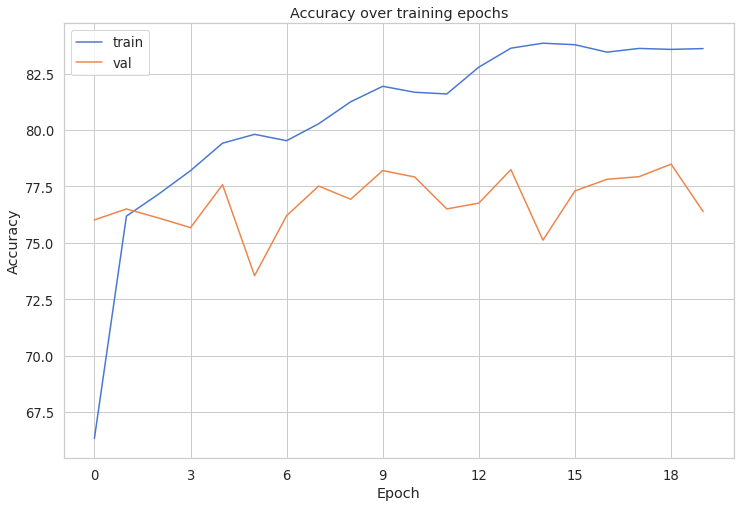

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history['train_acc'])
ax.plot(history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Accuracy over training epochs')
plt.show();

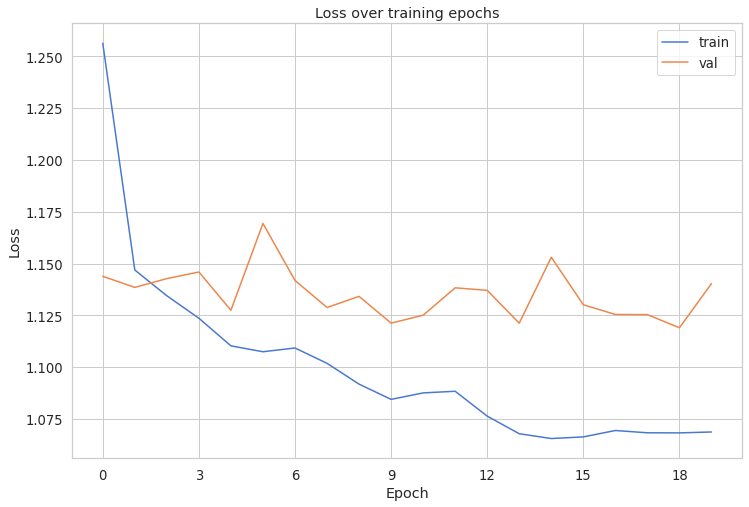

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history['train_loss'])
ax.plot(history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.title('Loss over training epochs')
plt.show();

The models seems to be getting overfitted. However, many regularizations techniques can be followed to battle this. Please check [this article](https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/) to learn about some of the potential techniques.

In [ ]:
# load the best performing model
model = ClassifierClass(len(df_train['rating'].unique()))
model.load_state_dict(torch.load('model.bin'))
model = model.to(device)

In [ ]:
def test(model, data_loader, holdout=0):
  '''
  input: model, data_loader, holdout=0 : checks if the data is holdout or not
  output: review_texts, predictions, prediction_probabilities, real_values
  This method takes the test data and calculates accuracy
  '''
  model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for _, data in enumerate(data_loader):

      texts = data['review_text']
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      outputs = model(ids, mask).squeeze()
      big_val, preds = torch.max(outputs.data, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      if not holdout:
        targets = data['targets'].to(device, dtype = torch.long)
        real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()

  if not holdout:
    real_values = torch.stack(real_values).cpu()
  

  return review_texts, predictions, prediction_probs, real_values 


### Check the performance for the test data

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = test(model, test_loader, holdout=0)

In [ ]:
# Classificaiton metrics - precision, recall, f1, and accuracy
def get_metrics(y_test, y_predicted): 
  '''
  input: y_test, y_pred
  output: accuracy, precision, recall, f1
  This method calculates the performance of the model.
  '''
  # true positives / (true positives+false positives)
  precision = precision_score(y_test, y_predicted, pos_label=None,
                                  average='weighted')             
  # true positives / (true positives + false negatives)
  recall = recall_score(y_test, y_predicted, pos_label=None,
                            average='weighted')
  
  # harmonic mean of precision and recall
  f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
  
  # true positives + true negatives/ total
  accuracy = accuracy_score(y_test, y_predicted)
  return accuracy, precision, recall, f1

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
  '''
  input: y_true, y_pred, title, figsize
  This method plots the confusion matrix
  '''
  cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
  cm_sum = np.sum(cm, axis=1, keepdims=True)
  cm_perc = cm / cm_sum.astype(float) * 100
  annot = np.empty_like(cm).astype(str)
  nrows, ncols = cm.shape
  for i in range(nrows):
      for j in range(ncols):
          c = cm[i, j]
          p = cm_perc[i, j]
          if i == j:
              s = cm_sum[i]
              annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
          elif c == 0:
              annot[i, j] = ''
          else:
              annot[i, j] = '%.1f%%\n%d' % (p, c)
  cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  fig, ax = plt.subplots(figsize=figsize)
  plt.title(title)
  sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [ ]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.791 
precision = 0.793 
recall = 0.791 
f1 = 0.792


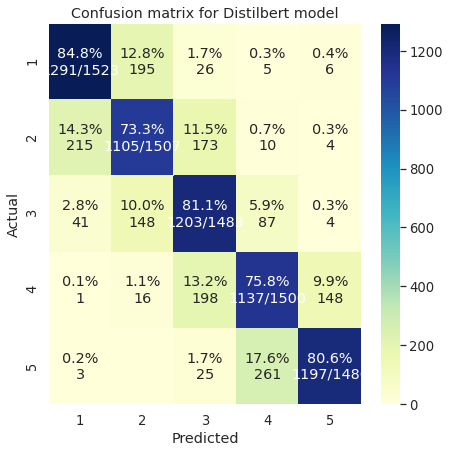

In [ ]:
# Showing Confusion Matrix for bow model
plot_cm([x+1 for x in y_test], [x+1 for x in y_pred], 'Confusion matrix for Distilbert model', figsize=(7,7))

### Calculate the performance for the holdout data

In [ ]:
y_review_texts_holdout, y_pred_holdout, y_pred_probs_holdout, y_test_holdout = test(model, holdout_loader, holdout=1)

In [ ]:
df_test['predicted_sota'] = [x+1 for x in y_pred_holdout.tolist()]
df_test.to_csv('sentiment_processed_test.csv')

# Save the model

In [ ]:
#model=model.to(device)
PATH_1= "model_dict.pt"
torch.save(model.state_dict(),PATH_1)

PATH_2="model.pt"
torch.save(model,PATH_2)